**Collaborative Filtering to recommend movies using Keras**

**Dataset**:  MovieLens      
**Goal**:  To be able to predict ratings for movies a user has not yet watched. The movies with the highest predicted ratings can then be recommended to the user. Our task is to predict the rating for a user/movie pair, with the idea that if we had a model that's good at this task then we could predict how a user would rate movies they haven't seen yet and recommend movies with the highest predicted rating


1. With the help of Embedding matrix, user ID is mapped to a "user vector".
2. With the help of Embedding matrix, movie ID is mapped to a "movie vector".
3. To predict rating, dot product is computed between user vector and movie vector. 
4. Trained the embeddings via gradient descent using all known user-movie pairs.


References:
1. https://keras.io/getting_started/intro_to_keras_for_engineers/
2. https://towardsdatascience.com/supervised-machine-learning-model-validation-a-step-by-step-approach-771109ae025
3. https://towardsdatascience.com/machine-learning-model-regularization-in-practice-an-example-with-keras-and-tensorflow-2-0-52a96746123e
4. https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
5. https://towardsdatascience.com/neural-collaborative-filtering-96cef1009401

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
 
from zipfile import ZipFile
from pathlib import Path
import matplotlib.pyplot as plt

**Google drive mounting**  (Please read the compilation procedure pdf)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load the data**

In [ ]:
df = pd.read_csv("/content/drive/My Drive/ratings.csv")
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


**Need to perform some preprocessing to encode users and movies as integer indices.**

The user/movie fields are currently non-sequential integers representing some unique ID for that entity. We need them to be sequential starting at zero to use for modeling. We can use enumerate class and lambda expression to transform the fields. Also I have created variables with the total number of unique users and movies in the data, as well as the min and max ratings present in the data

In [ ]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

movie_ids = df["movieId"].unique().tolist()

 # Lambda expression to encode movie and user
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

# Adding 2 columns to the original dataset
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

# Total count of users and movies
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)

# rating column to convert uneven format of numbers to float 32 bit
df["rating"] = df["rating"].values.astype(np.float32)

# min and max ratings is used to normalize the ratings 
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


**Prepare training and validation data**

Create a traditional (x, y) pairing of data and label, then split the data into training and test data sets.

In [ ]:
# Keeping the same randoms
df = df.sample(frac=1, random_state=42)

# 'x' contains user and movie column
x = df[["user", "movie"]].values

# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Assuming training on 80% of the data and validating on 20%.
train_indices = int(0.8 * df.shape[0])

# Splitting training and validation dataset
x_train, x_val, y_train, y_val = ( x[:train_indices], x[train_indices:], y[:train_indices], y[train_indices:],)

**Model**


The main idea here is to use embeddings to represent each user and each movie in the data. These embeddings will be vectors (of size n_factors) that start out as random numbers but are fit by the model to capture the essential qualities of each user/movie. We can accomplish this by computing the dot product between a user vector and a movie vector to get a predicted rating. 

In [ ]:
# 50 Dimensional vector
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    # Softmax activation plus a Cross-Entropy loss
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy']
)

**Train the model based on the data split**

In [ ]:
history = model.fit(x=x_train, y=y_train, verbose=1,batch_size=64, epochs=5, validation_data=(x_val, y_val))

Epoch 1/5
1261/1261 [==============================] - 8s 6ms/step - loss: 0.6590 - accuracy: 0.1167 - val_loss: 0.6208 - val_accuracy: 0.1308
Epoch 2/5
1261/1261 [==============================] - 7s 6ms/step - loss: 0.6186 - accuracy: 0.1303 - val_loss: 0.6192 - val_accuracy: 0.1334
Epoch 3/5
1261/1261 [==============================] - 7s 5ms/step - loss: 0.6106 - accuracy: 0.1336 - val_loss: 0.6125 - val_accuracy: 0.1340
Epoch 4/5
1261/1261 [==============================] - 7s 5ms/step - loss: 0.6083 - accuracy: 0.1332 - val_loss: 0.6110 - val_accuracy: 0.1339
Epoch 5/5
1261/1261 [==============================] - 7s 6ms/step - loss: 0.6070 - accuracy: 0.1343 - val_loss: 0.6129 - val_accuracy: 0.1333


In [ ]:
model.summary()

Model: "recommender_net_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_48 (Embedding)     multiple                  30500     
_________________________________________________________________
embedding_49 (Embedding)     multiple                  610       
_________________________________________________________________
embedding_50 (Embedding)     multiple                  486200    
_________________________________________________________________
embedding_51 (Embedding)     multiple                  9724      
Total params: 527,034
Trainable params: 527,034
Non-trainable params: 0
_________________________________________________________________


**Plot training and validation loss**

In [ ]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and Test '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

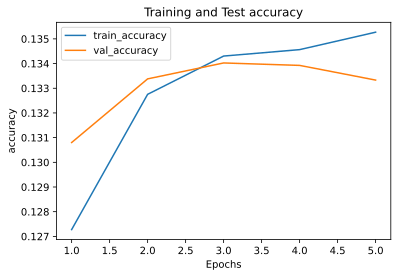

In [ ]:
plot_metric(history, 'accuracy')

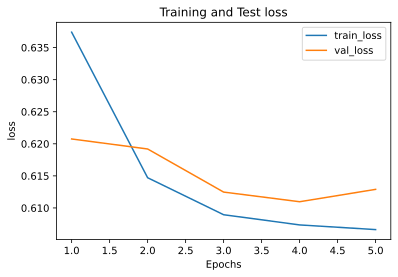

In [ ]:
plot_metric(history, 'loss')

We can see that the overfitting it not completely fixed, but there is a significant improvement

**Show top 10 movie recommendations to a user**

In [ ]:
movie_df = pd.read_csv("/content/drive/My Drive/movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]

# Movies watched by user
movies_watched_by_user = df[df.userId == user_id]

# Movies not watched by user
movies_not_watched = movie_df[~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]

# Making a list of movies not watched
movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))

movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched))
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices]

print("User: {}".format(user_id))
print("====" * 9)
print("")
print("Movies with high ratings from user:- ")
print("")

top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values)

movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]

for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("====" * 9)
print(" ")
print("Recommendations: Top 10 movies :-")
print(" ")

recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]

for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

User: 325

Movies with high ratings from user:- 

Platoon (1986) : Drama|War
Ran (1985) : Drama|War
Psycho (1960) : Crime|Horror
Last Detail, The (1973) : Comedy|Drama
Rashomon (Rashômon) (1950) : Crime|Drama|Mystery
 
Recommendations: Top 10 movies :-
 
Fargo (1996) : Comedy|Crime|Drama|Thriller
One Flew Over the Cuckoo's Nest (1975) : Drama
Shining, The (1980) : Horror
Stand by Me (1986) : Adventure|Drama
Evil Dead II (Dead by Dawn) (1987) : Action|Comedy|Fantasy|Horror
Groundhog Day (1993) : Comedy|Fantasy|Romance
Cool Hand Luke (1967) : Drama
Young Frankenstein (1974) : Comedy|Fantasy
This Is Spinal Tap (1984) : Comedy
Indiana Jones and the Last Crusade (1989) : Action|Adventure
